# Financial Influence

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from IPython.display import display
from scipy.stats import pearsonr, spearmanr

## Key Terms

### Salary Cap  
The official spending limit set by the NBA on total player salaries per team each season.

### Team Salary (Team Cap)  
The actual total amount a team disburses on player contracts. Can be below, equal to, or above the official cap.

### Soft Cap System  
A cap structure that allows teams to exceed the salary cap under specific exceptions, such as:  
- **Bird Rights**: Re-signing own players above the cap  
- **Mid-Level Exception**: Signing free agents even when over the cap  
- **Rookie Exception**: Draft picks don’t count against the cap

### Luxury Tax  
A financial penalty paid by teams that exceed a designated tax threshold. The more they exceed it, the higher the tax rate.

## Salary Cap

The salary cap data was exported from Basketball Reference, a highly trusted and widely used website for historical and statistical NBA data. You can find the full salary-cap history here:
https://www.basketball-reference.com/contracts/salary-cap-history.html

Basketball Reference is part of the Sports Reference network and is regularly cited by journalists, analysts, and researchers in the sports industry. The inflation-adjusted values (“2022 Dollars”) were provided directly on the site, based on Consumer Price Index (CPI) data from the Minneapolis Federal Reserve. On that page, you can also download the dataset as a CSV file.

In [2]:
import pandas as pd

# Local path to the downloaded CSV file
file_path = "data/NBA_Salary_Cap_History.csv"

# Read the CSV into a DataFrame
salary_cap_history = pd.read_csv(file_path)

# Convert the "2022 Dollars" column to integer type
salary_cap_history["2022 Dollars"] = salary_cap_history["2022 Dollars"].astype("Int64")

# Display the first few rows
print(salary_cap_history)

     Season  Salary Cap  2022 Dollars
0   1984-85     3600000       9793069
1   1985-86     4233000      11298280
2   1986-87     4945000      12734751
3   1987-88     6164000      15248702
4   1988-89     7232000      17069461
5   1989-90     9802000      21950887
6   1990-91    11871000      25499592
7   1991-92    12500000      26061180
8   1992-93    14000000      28354756
9   1993-94    15175000      29954782
10  1994-95    15964000      30651995
11  1995-96    23000000      42906004
12  1996-97    24363000      44402880
13  1997-98    26900000      48285994
14  1998-99    30000000      52688773
15  1999-00    34000000      57763864
16  2000-01    35500000      58657395
17  2001-02    42500000      69132284
18  2002-03    40271000      64048956
19  2003-04    43840000      67907202
20  2004-05    43870000      65719039
21  2005-06    49500000      71839551
22  2006-07    53135000      74973988
23  2007-08    55630000      75594893
24  2008-09    58680000      80023973
25  2009-10 

### Note on Missing Inflation-Adjusted Values

The seasons **2022-23** and **2023-24** originally show <NA> in the 2022 Dollars column. To fill these gaps, we used the Minneapolis Fed Inflation Calculator:  
https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/

- **2022-23**: $1 in 2023 is worth $0.96 in 2022 → multiplied raw cap by **0.96**  
- **2023-24**: $1 in 2024 is worth $0.93 in 2022 → multiplied raw cap by **0.93**

The **2024-25** season remains `<NA>`, since CPI data for that period are not yet finalized.

In [3]:
# Manually fill in the missing “2022 Dollars” for seasons 2022-23 and 2023-24
# using the Minneapolis Fed inflation factors we looked up:

# 2022-23: $1 in 2023 ≈ $0.96 in 2022
mask_22_23 = salary_cap_history["Season"] == "2022-23"
salary_cap_history.loc[mask_22_23, "2022 Dollars"] = (
    salary_cap_history.loc[mask_22_23, "Salary Cap"] * 0.96
)

# 2023-24: $1 in 2024 ≈ $0.93 in 2022
mask_23_24 = salary_cap_history["Season"] == "2023-24"
salary_cap_history.loc[mask_23_24, "2022 Dollars"] = (
    salary_cap_history.loc[mask_23_24, "Salary Cap"] * 0.93
)

# Drop any remaining rows with missing “2022 Dollars” (e.g. 2024-25)
salary_cap_history = salary_cap_history.dropna(subset=["2022 Dollars"]).reset_index(drop=True)

# Display the last two rows (2022-23 and 2023-24)
print(salary_cap_history.tail(2))

     Season  Salary Cap  2022 Dollars
38  2022-23   123655000     118708800
39  2023-24   136021000     126499530


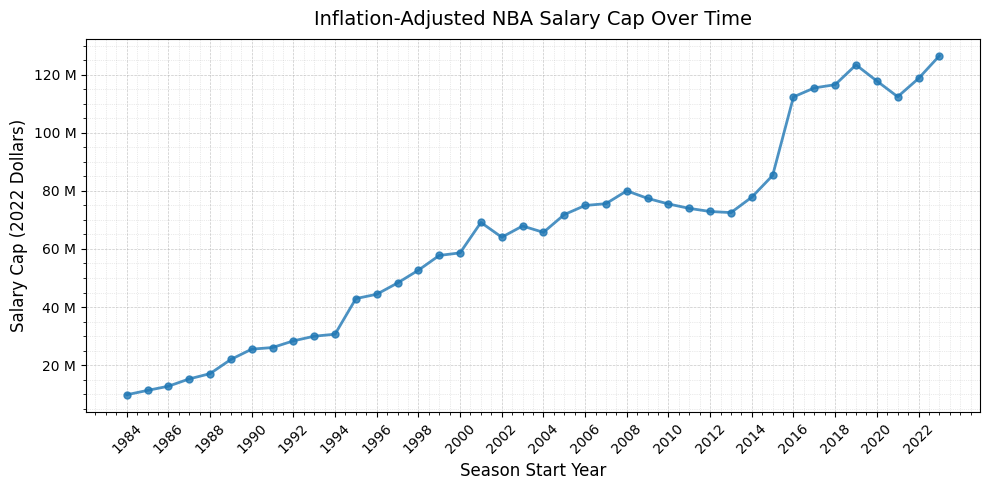

In [4]:
# Ensure numeric "YearStart" column exists
salary_cap_history['YearStart'] = (
    salary_cap_history['Season']
    .str.split('-')
    .str[0]
    .astype(int)
)

# Create figure & axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot with markers, thicker line and slight transparency
ax.plot(
    salary_cap_history['YearStart'],
    salary_cap_history['2022 Dollars'],
    marker='o',
    linewidth=2,
    markersize=5,
    alpha=0.8
)

# Format y-axis labels in millions
ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f} M")
)

# Major and minor grid lines
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Labels and title
ax.set_xlabel('Season Start Year', fontsize=12)
ax.set_ylabel('Salary Cap (2022 Dollars)', fontsize=12)
ax.set_title('Inflation-Adjusted NBA Salary Cap Over Time', fontsize=14, pad=10)

# Ticks: every 2 seasons, rotated
years = salary_cap_history['YearStart']
ax.set_xticks(years[::2])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Slow and Steady Rise: From the mid-1980s through the early 2010s, the salary cap (adjusted for inflation) climbed gradually.

2008–09 Dip: During the global financial crisis, NBA revenue took a small hit, so the cap leveled off for a couple of seasons.

Big 2015–16 Jump: Then, thanks to a massive new TV deal ($24 billion over nine years with ESPN/ABC and Turner) the cap jumped from around $68 million to $90 million in one season (a 30 percent spike). For details on that agreement, see the Sports Illustrated article: https://www.si.com/nba/2014/10/06/new-nba-tv-deal-worth-24-billion

Continued Growth: After that, the cap kept rising to new highs, driven by further media contracts and the NBA’s expanding global business.

## Team Salary

### NBA Team Salary Data Extraction

In this section, we scrape team payroll figures from (https://hoopshype.com/salaries/) for each season between 1990-91 and 2024-25. The script retrieves both nominal and inflation-adjusted salaries, saves them to a CSV, and prepares the data for subsequent analysis of team spending trends.

In [5]:
#from selenium import webdriver
#from selenium.webdriver.chrome.service import Service
#from selenium.webdriver.common.by import By
#import pandas as pd
#import time
#import os
#
## === Fixed chromedriver path (adjust if needed)
#chrome_driver_path = r"C:\Users\chris\Documents\nba_data\chromedriver-win64\chromedriver.exe"
#service = Service(executable_path=chrome_driver_path)
#driver = webdriver.Chrome(service=service)
#
## === Fixed output path
#output_path = "data/team_salaries_1990_2024.csv"
#
## === Scraping loop
#all_seasons_data = []
#
#for year_start in range(1990, 2024):  # Up to and including 2023/24
#    year_end = year_start + 1
#    url = f"https://hoopshype.com/salaries/archive/{year_start}-{year_end}/"
#    print(f"Scraping {year_start}/{str(year_end)[-2:]} from {url}")
#
#    try:
#        driver.get(url)
#        time.sleep(5)
#
#        rows = driver.find_elements(By.CSS_SELECTOR, "table tbody tr")
#
#        for row in rows:
#            cols = row.find_elements(By.TAG_NAME, "td")
#            if len(cols) >= 4:
#                team = cols[1].text.strip()
#                nominal = cols[2].text.strip().replace("$", "").replace(",", "")
#                adjusted = cols[3].text.strip().replace("$", "").replace(",", "")
#                all_seasons_data.append({
#                    "Season": f"{year_start}/{str(year_end)[-2:]}",
#                    "Team": team,
#                    "Team Salary": int(nominal) if nominal.isdigit() else None,
#                    "Team Salary Adjusted": int(adjusted) if adjusted.isdigit() else None
#                })
#
#    except Exception as e:
#        print(f"Error scraping {year_start}/{str(year_end)[-2:]}: {e}")
#
## === Final save
#driver.quit()
#df = pd.DataFrame(all_seasons_data)
#
#try:
#    df.to_csv(output_path, index=False)
#    print(f"\n CSV successfully saved to:\n{output_path}")
#except Exception as e:
#    print(f"\n Failed to save CSV:\n{e}")



It is recommended to download the scraped CSV locally (to guard against future website changes) and then load it for analysis:


In [6]:
# Load the team salaries dataset
file_path = "data/team_salaries_1990_2024.csv"
team_salaries = pd.read_csv(file_path)

# Basic inspections
print("Shape:", team_salaries.shape)
team_salaries.info()

print("\nMissing values per column:\n", team_salaries.isnull().sum())
print("\nSeasons covered:\n", team_salaries["Season"].value_counts().sort_index())

Shape: (996, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Season                996 non-null    object
 1   Team                  996 non-null    object
 2   Team Salary           996 non-null    int64 
 3   Team Salary Adjusted  996 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 31.2+ KB

Missing values per column:
 Season                  0
Team                    0
Team Salary             0
Team Salary Adjusted    0
dtype: int64

Seasons covered:
 Season
1990/91    27
1991/92    27
1992/93    27
1993/94    27
1994/95    27
1995/96    29
1996/97    29
1997/98    29
1998/99    29
1999/00    29
2000/01    29
2001/02    29
2002/03    29
2003/04    29
2004/05    30
2005/06    30
2006/07    30
2007/08    30
2008/09    30
2009/10    30
2010/11    30
2011/12    30
2012/13    30
2013/14    30
2014/15    30
2015/16

The dataset contains 996 entries across four columns: Season, Team, Team Salary, and Team Salary Adjusted.
There are no missing values in any of the columns, ensuring a complete and clean dataset for analysis.
It covers NBA seasons from 1990/91 to 2023/24, with the number of teams per season reflecting the league's historical expansion from 27 to 30 teams.

In [7]:
team_salaries[team_salaries["Season"] == "2021/22"].sort_values("Team Salary Adjusted", ascending=False)

,Season,Team,Team Salary,Team Salary Adjusted
906,2021/22,Golden State,178980766,206963957
907,2021/22,Brooklyn,174811922,202143321
908,2021/22,LA Clippers,168378382,194703915
909,2021/22,LA Lakers,164409293,190114264
910,2021/22,Milwaukee,160875421,186027881
911,2021/22,Utah,149760719,173175425
912,2021/22,Philadelphia,148922969,172206695
913,2021/22,Miami,140840240,162860249
914,2021/22,Indiana,138181486,159785807
915,2021/22,Denver,137963926,159534234


I ran a quick spot check and the scraped salaries match what’s on the site. The scrape finished without errors, and all seasons from 1990-91 to 2023-24 are in the CSV. The dataset is now ready for first-round EDA.

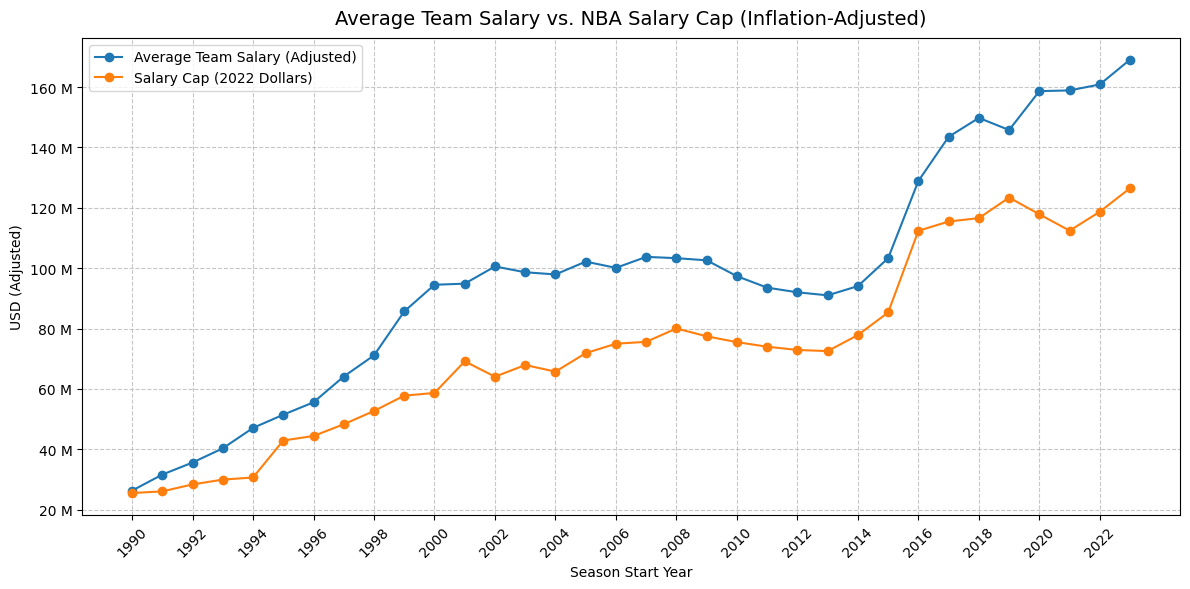

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Step 1: Prepare team salary data
team_salaries['SeasonStart'] = team_salaries['Season'].str[:4].astype(int)
avg_team_salary = (
    team_salaries
    .groupby('SeasonStart')['Team Salary Adjusted']
    .mean()
    .reset_index()
)

# Step 2: Merge with salary cap data (on SeasonStart == YearStart)
salary_cap_history['YearStart'] = salary_cap_history['Season'].str.split('-').str[0].astype(int)
merged = pd.merge(
    avg_team_salary,
    salary_cap_history[['YearStart', '2022 Dollars']],
    left_on='SeasonStart',
    right_on='YearStart',
    how='inner'
)

# Step 3: Plot both lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot average team salary
ax.plot(
    merged['SeasonStart'],
    merged['Team Salary Adjusted'],
    label='Average Team Salary (Adjusted)',
    color='tab:blue',
    marker='o'
)

# Plot salary cap
ax.plot(
    merged['SeasonStart'],
    merged['2022 Dollars'],
    label='Salary Cap (2022 Dollars)',
    color='tab:orange',
    marker='o'
)

# Format y-axis in millions
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f} M"))

# Titles and labels
ax.set_title('Average Team Salary vs. NBA Salary Cap (Inflation-Adjusted)', fontsize=14, pad=10)
ax.set_xlabel('Season Start Year')
ax.set_ylabel('USD (Adjusted)')
ax.legend()
ax.grid(True, which='major', linestyle='--', alpha=0.7)

# Ticks and layout
ax.set_xticks(merged['SeasonStart'][::2])
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


Plot Interpretation – Average Team Salary vs. NBA Salary Cap (Inflation-Adjusted):

The plot compares the average inflation-adjusted NBA team salaries with the official salary cap (also adjusted for inflation) from 1990/91 to 2023/24.
It clearly shows that, on average, teams consistently spend more than the official cap allows a result of the NBA's soft cap system, which permits teams to exceed the limit through various exceptions.
Notable jumps in spending, particularly after 2016, reflect significant external factors such as new TV deals, while the dip around 2020–2021 is likely due to the financial impact of the COVID-19 pandemic.
Overall, the trend highlights the league's increasing financial power and teams growing willingness to invest beyond the cap to remain competitive.

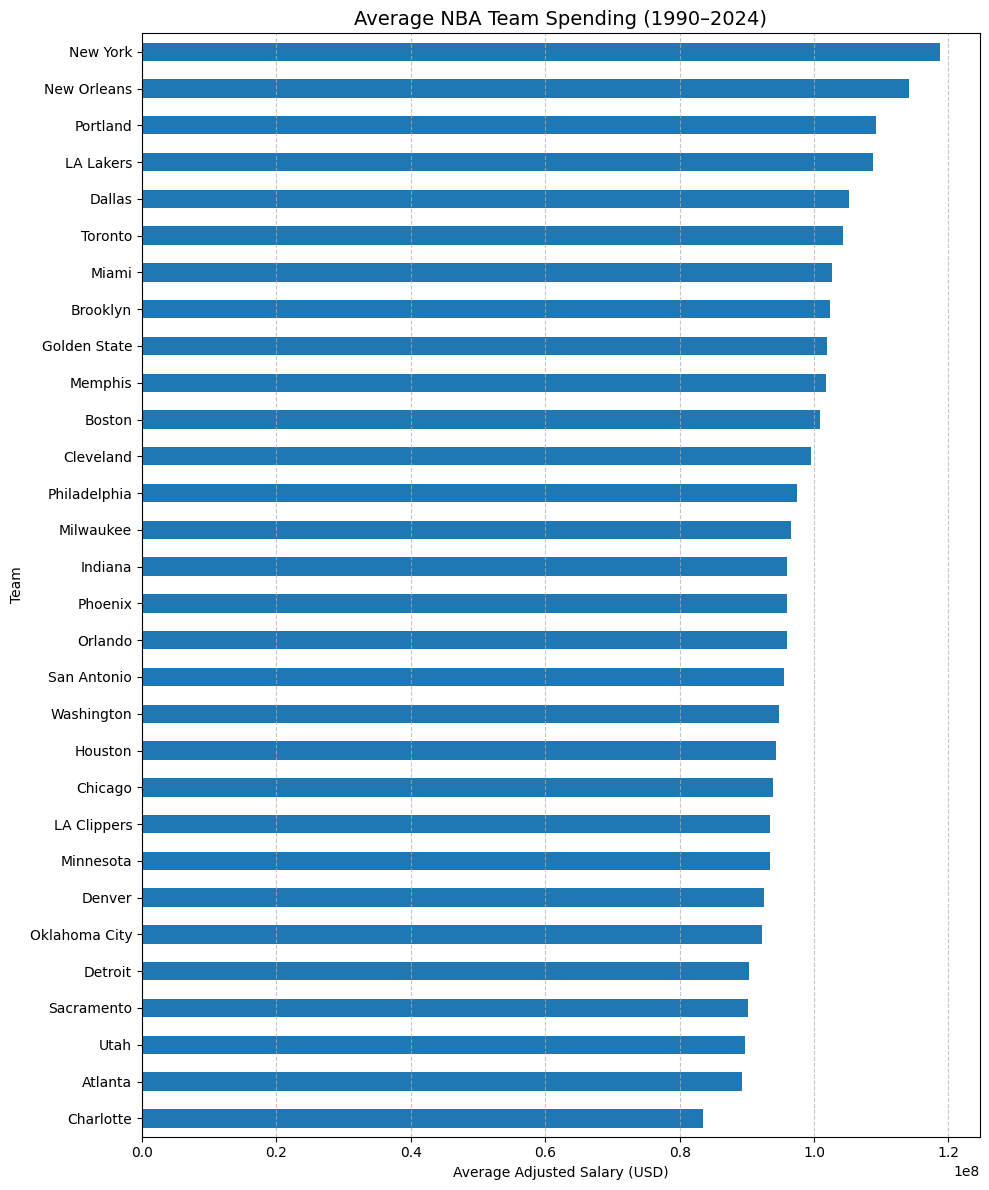

In [9]:
# Average salary per team over all seasons (already sorted)
avg_salary_per_team = (
    team_salaries
    .groupby('Team')['Team Salary Adjusted']
    .mean()
    .sort_values(ascending=False)
)

# Plot all 30 teams
avg_salary_per_team.plot(kind='barh', figsize=(10, 12), color='tab:blue')
plt.xlabel('Average Adjusted Salary (USD)')
plt.title('Average NBA Team Spending (1990–2024)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Top spending NBA team per season (1990/91 – 2023/24):
     Season           Team  Team Salary Adjusted
0   1990/91      Cleveland              34834960
1   1991/92         Boston              58545115
2   1992/93         Boston              56508912
3   1993/94      Cleveland              51588659
4   1994/95      LA Lakers              89302750
5   1995/96       New York              89264835
6   1996/97        Chicago             116828182
7   1997/98        Chicago             120203133
8   1998/99       New York             115541991
9   1999/00       Portland             139693887
10  2000/01       Portland             159265467
11  2001/02       New York             151780123
12  2002/03       Portland             184410864
13  2003/04       New York             152974005
14  2004/05       New York             169869031
15  2005/06       New York             204546649
16  2006/07       New York             181708756
17  2007/08         Dallas             153346197
18  2008/09    

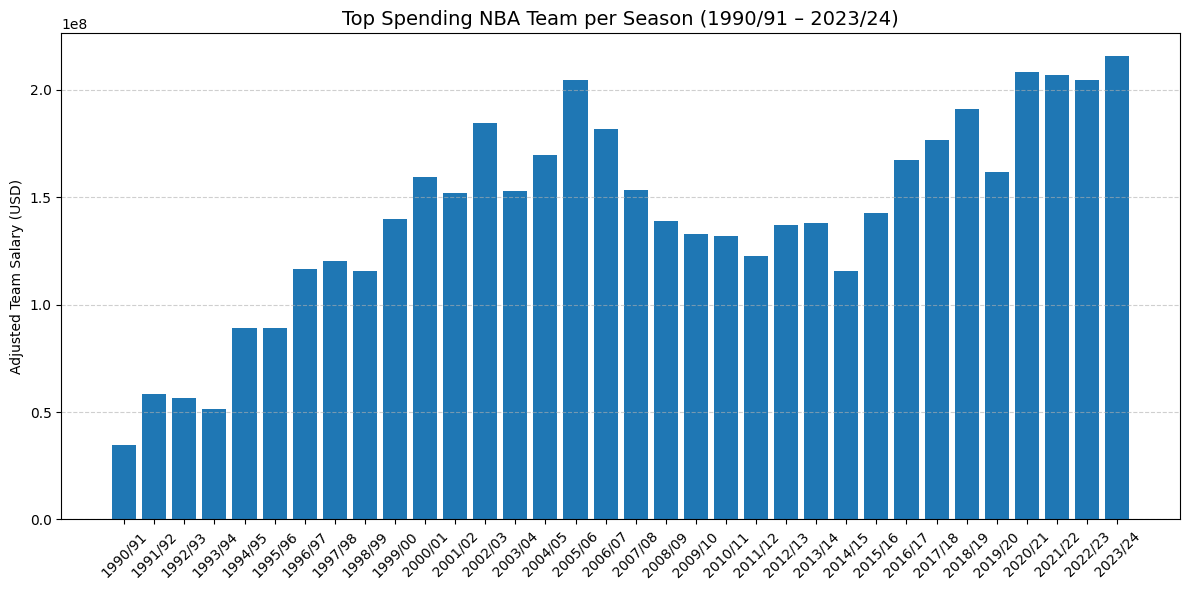

In [10]:
# Identify the top-spending team in each season (adjusted salary)
top_spender_per_season = (
    team_salaries
    .loc[team_salaries.groupby('Season')['Team Salary Adjusted'].idxmax()]
    .sort_values('Season')
    .reset_index(drop=True)
)

# Display the top spenders per season
print("Top spending NBA team per season (1990/91 – 2023/24):")
print(top_spender_per_season[['Season', 'Team', 'Team Salary Adjusted']])

# Plot the adjusted salary of the top team each season
plt.figure(figsize=(12, 6))
plt.bar(
    top_spender_per_season['Season'],
    top_spender_per_season['Team Salary Adjusted'],
    color='tab:blue'
)
plt.xticks(rotation=45)
plt.ylabel('Adjusted Team Salary (USD)')
plt.title('Top Spending NBA Team per Season (1990/91 – 2023/24)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [11]:
# Load the dataset as 'team_statistics'
team_statistics = pd.read_csv("data/TeamStatistics_uncleaned.csv")

# Display all column names
print("Column names:")
print(team_statistics.columns)

# Display first 5 rows
print("\nSample data:")
print(team_statistics.head())

Column names:
Index(['gameId', 'gameDate', 'teamCity', 'teamName', 'teamId',
       'opponentTeamCity', 'opponentTeamName', 'opponentTeamId', 'home', 'win',
       'teamScore', 'opponentScore', 'assists', 'blocks', 'steals',
       'fieldGoalsAttempted', 'fieldGoalsMade', 'fieldGoalsPercentage',
       'threePointersAttempted', 'threePointersMade',
       'threePointersPercentage', 'freeThrowsAttempted', 'freeThrowsMade',
       'freeThrowsPercentage', 'reboundsDefensive', 'reboundsOffensive',
       'reboundsTotal', 'foulsPersonal', 'turnovers', 'plusMinusPoints',
       'numMinutes', 'q1Points', 'q2Points', 'q3Points', 'q4Points',
       'benchPoints', 'biggestLead', 'biggestScoringRun', 'leadChanges',
       'pointsFastBreak', 'pointsFromTurnovers', 'pointsInThePaint',
       'pointsSecondChance', 'timesTied', 'timeoutsRemaining', 'seasonWins',
       'seasonLosses', 'coachId'],
      dtype='object')

Sample data:
     gameId             gameDate     teamCity teamName      teamId  \

In [12]:
# There are no missing values in the relevant columns, so we don't need to drop any rows.

essential_columns = [
    'gameId',          # Unique game identifier
    'gameDate',        # For determining season
    'teamCity',        # Team identification (part 1)
    'teamName',        # Team identification (part 2)
    'win',             # Win/loss record
    'home',            # Home vs. away analysis
    'teamScore',       # For point differential
    'opponentScore'    # For point differential
]

team_statistics = team_statistics[essential_columns].copy()

In [13]:
# Mapping from 'team_statistics' names to 'team_salaries' names
team_name_mapping = {
    'Atlanta Hawks': 'Atlanta',
    'Boston Celtics': 'Boston',
    'Brooklyn Nets': 'Brooklyn',
    'Charlotte Hornets': 'Charlotte',
    'Charlotte Bobcats': 'Charlotte',
    'Chicago Bulls': 'Chicago',
    'Cleveland Cavaliers': 'Cleveland',
    'Dallas Mavericks': 'Dallas',
    'Denver Nuggets': 'Denver',
    'Detroit Pistons': 'Detroit',
    'Golden State Warriors': 'Golden State',
    'Houston Rockets': 'Houston',
    'Indiana Pacers': 'Indiana',
    'Los Angeles Clippers': 'LA Clippers',
    'San Diego Clippers': 'LA Clippers',
    'Los Angeles Lakers': 'LA Lakers',
    'Memphis Grizzlies': 'Memphis',
    'Miami Heat': 'Miami',
    'Milwaukee Bucks': 'Milwaukee',
    'Minnesota Timberwolves': 'Minnesota',
    'New Orleans Hornets': 'New Orleans',
    'New Orleans Pelicans': 'New Orleans',
    'New York Knicks': 'New York',
    'Oklahoma City Thunder': 'Oklahoma City',
    'Oklahoma City Hornets': 'Oklahoma City',
    'Orlando Magic': 'Orlando',
    'Philadelphia 76ers': 'Philadelphia',
    'Phoenix Suns': 'Phoenix',
    'Portland Trail Blazers': 'Portland',
    'Sacramento Kings': 'Sacramento',
    'Kansas City Kings': 'Sacramento',
    'San Antonio Spurs': 'San Antonio',
    'Seattle SuperSonics': 'Oklahoma City', 
    'Toronto Raptors': 'Toronto',
    'Utah Jazz': 'Utah',
    'Vancouver Grizzlies': 'Memphis',
    'Washington Bullets': 'Washington',
    'Washington Wizards': 'Washington',
    'New Jersey Nets': 'Brooklyn'
}


In [14]:
# Create combined team name column
team_statistics['Team'] = team_statistics['teamCity'] + ' ' + team_statistics['teamName']

# Replace team names using the mapping
team_statistics['Team (mapped)'] = team_statistics['Team'].map(team_name_mapping)

# Check for missing mappings (just in case)
missing = team_statistics[team_statistics['Team (mapped)'].isnull()]['Team'].unique()
print("Teams without mapping (should be empty):", missing)

Teams without mapping (should be empty): ['New Orleans Jazz' 'Buffalo Braves' 'New York Nets'
 'Kansas City-Omaha Kings' 'Capital Bullets' 'Baltimore Bullets'
 'Cincinnati Royals' 'San Francisco Warriors' 'San Diego Rockets'
 'St. Louis Hawks' 'Syracuse Nationals' 'Chicago Zephyrs'
 'Philadelphia Warriors' 'Chicago Packers' 'Minneapolis Lakers'
 'Ft. Wayne Zollner Pistons' 'Rochester Royals' 'Milwaukee Hawks'
 'Tri-Cities Blackhawks']


### Analyis

- Created a propper datafram with all the necessary mappings.
- Now need to use 

In [15]:
# Step 1: Create the 'SeasonStart' column
# - Extract the year from 'gameDate'
# - NBA seasons starting after June belong to the previous calendar year
#   (e.g., October 2023 → 2023/24 season → SeasonStart = 2023)
team_statistics['SeasonStart'] = pd.to_datetime(team_statistics['gameDate']).dt.year
team_statistics['SeasonStart'] = team_statistics['SeasonStart'].where(
    pd.to_datetime(team_statistics['gameDate']).dt.month < 7,
    team_statistics['SeasonStart'] - 1
)

# Step 2: Filter to match salary data (1990–2024 only)
team_statistics = team_statistics[
    (team_statistics['SeasonStart'] >= 1990) &
    (team_statistics['SeasonStart'] <= 2024)
]

# Step 3: Aggregate the number of wins per team per season
# - Only select games where the team won
# - Group by 'Team (mapped)' and 'SeasonStart'
# - Count the number of wins per combination
team_wins = (
    team_statistics
    .groupby(['Team (mapped)', 'SeasonStart'])
    .agg(
        Wins=('win', lambda x: (x == True).sum()),  # Count wins
        Games_Played=('win', 'count')               # Count all games
    )
    .reset_index()
    .rename(columns={'Team (mapped)': 'Team'})  # Rename for easier merging later
)

# Add win percentage
team_wins['Win_Pct'] = (team_wins['Wins'] / team_wins['Games_Played'] * 100).round(1)

# Remove teams with less than 50 games played in a season
team_wins = team_wins[team_wins['Games_Played'] >= 50].reset_index(drop=True)

# Step 4: Preview the result
print(team_wins.head())

      Team  SeasonStart  Wins  Games_Played  Win_Pct
0  Atlanta         1990    38            83     45.8
1  Atlanta         1991    42            86     48.8
2  Atlanta         1992    44            80     55.0
3  Atlanta         1993    43            87     49.4
4  Atlanta         1994    56            95     58.9


In [16]:
print("All unique seasons (SeasonStart):")
print(sorted(team_wins['SeasonStart'].unique()))
print(team_wins[team_wins['Team'] == 'Chicago'])
print(team_wins[team_wins['Team'] == 'Golden State'])
print("Maximum number of wins per entry:", team_wins['Wins'].max())

All unique seasons (SeasonStart):
[np.int32(1990), np.int32(1991), np.int32(1992), np.int32(1993), np.int32(1994), np.int32(1995), np.int32(1996), np.int32(1997), np.int32(1998), np.int32(1999), np.int32(2000), np.int32(2001), np.int32(2002), np.int32(2003), np.int32(2004), np.int32(2005), np.int32(2006), np.int32(2007), np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024)]
        Team  SeasonStart  Wins  Games_Played  Win_Pct
137  Chicago         1990    70            98     71.4
138  Chicago         1991    77            98     78.6
139  Chicago         1992    76           103     73.8
140  Chicago         1993    66           101     65.3
141  Chicago         1994    68            93     73.1
142  Chicago         1995    64            95     67.4
143  Chicago        

In [17]:
# Step 1: Make sure 'SeasonStart' exists in both DataFrames
# Convert the 'Season' column (e.g., "1990/91") to an integer (e.g., 1990)
team_salaries['SeasonStart'] = team_salaries['Season'].str[:4].astype(int)

# Step 2: Merge the salary and win data on 'Team' and 'SeasonStart'
salary_with_wins = pd.merge(
    team_salaries,
    team_wins,
    on=['Team', 'SeasonStart'],
    how='inner'  # only keep records that exist in both datasets
)

# Step 3: Check the result
print("Merged dataset preview:")
print(salary_with_wins[['Season', 'Team', 'SeasonStart', 'Team Salary Adjusted', 'Wins']].head())

# Step 4: Check dimensions and missing values
print("\nShape:", salary_with_wins.shape)
print("\nMissing values per column:")
print(salary_with_wins.isnull().sum())


Merged dataset preview:
    Season       Team  SeasonStart  Team Salary Adjusted  Wins
0  1990/91  Cleveland         1990              34834960    52
1  1990/91   New York         1990              32143071    47
2  1990/91    Detroit         1990              31224004    71
3  1990/91  LA Lakers         1990              29313318    63
4  1990/91    Atlanta         1990              28445044    38

Shape: (990, 8)

Missing values per column:
Season                  0
Team                    0
Team Salary             0
Team Salary Adjusted    0
SeasonStart             0
Wins                    0
Games_Played            0
Win_Pct                 0
dtype: int64


We will now calculate Cost per Win for each NBA team across all seasons from 1990 to 2024.
This metric is defined as the adjusted team salary divided by the number of regular season wins in a given year.

- It gives us a standardized efficiency metric: how much money did each team spend to win a single game.

- We can compare high-spending but underperforming teams vs. low-budget overachievers

In [18]:
# Step 1: Calculate Cost per Win (in adjusted dollars)
salary_with_wins['Cost per Win'] = (
    salary_with_wins['Team Salary Adjusted'] / salary_with_wins['Wins']
).round(2)

# Step 2: Preview sorted by highest cost (least efficient)
most_expensive_per_win = salary_with_wins.sort_values('Cost per Win', ascending=False).head(10)
print(" 10 Least Efficient Teams (Most Expensive Wins):")
print(most_expensive_per_win[['Season', 'Team', 'Wins', 'Team Salary Adjusted', 'Cost per Win']])

# Step 3: Preview sorted by lowest cost (most efficient)
most_efficient_per_win = salary_with_wins.sort_values('Cost per Win', ascending=True).head(10)
print("\n 10 Most Efficient Teams (Least Cost per Win):")
print(most_efficient_per_win[['Season', 'Team', 'Wins', 'Team Salary Adjusted', 'Cost per Win']])


 10 Least Efficient Teams (Most Expensive Wins):
      Season         Team  Wins  Team Salary Adjusted  Cost per Win
843  2019/20    Cleveland    16             160751868   10046991.75
895  2020/21      Detroit    15             142637587    9509172.47
866  2019/20     New York    13             122940807    9456985.15
592  2010/11     Brooklyn    10              84316177    8431617.70
863  2019/20      Chicago    17             138113087    8124299.24
597  2010/11    Minnesota    10              77058915    7705891.50
853  2019/20   Washington    20             148777244    7438862.20
821  2018/19     New York    21             153837075    7325575.00
452  2006/07     New York    26             181708756    6988798.31
969  2023/24  New Orleans    25             172378150    6895126.00

 10 Most Efficient Teams (Least Cost per Win):
     Season         Team  Wins  Team Salary Adjusted  Cost per Win
21  1990/91      Chicago    70              24282651     346895.01
11  1990/91     Portl

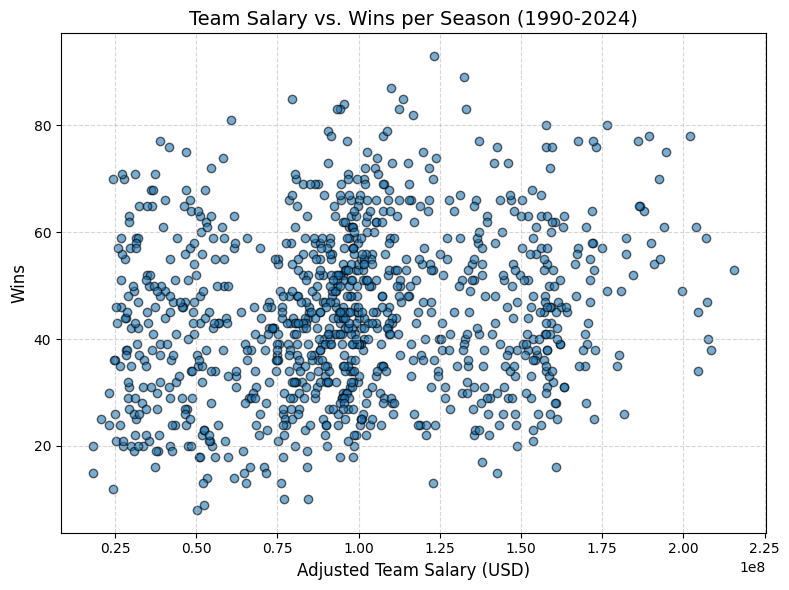

Pearson correlation (linear): 0.186
p-value: 0.0
Spearman correlation (rank-based): 0.19
p-value: 0.0


In [19]:
# Scatterplot – Team Salary vs. Wins
plt.figure(figsize=(8, 6))
plt.scatter(
    salary_with_wins['Team Salary Adjusted'],
    salary_with_wins['Wins'],
    alpha=0.6,
    edgecolors='k'
)
plt.xlabel('Adjusted Team Salary (USD)', fontsize=12)
plt.ylabel('Wins', fontsize=12)
plt.title('Team Salary vs. Wins per Season (1990-2024)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Calculate Pearson and Spearman correlation
pearson_corr, pearson_p = pearsonr(
    salary_with_wins['Team Salary Adjusted'],
    salary_with_wins['Wins']
)

spearman_corr, spearman_p = spearmanr(
    salary_with_wins['Team Salary Adjusted'],
    salary_with_wins['Wins']
)

# Print results
print("Pearson correlation (linear):", round(pearson_corr, 3))
print("p-value:", round(pearson_p, 5))

print("Spearman correlation (rank-based):", round(spearman_corr, 3))
print("p-value:", round(spearman_p, 5))


In [20]:
salary_with_wins.to_csv("data/salary_with_wins.csv", index=False)

The scatterplot shows a very weak positive relationship between inflation-adjusted team salaries and regular season wins. While some high-spending teams achieve strong results, many others do not, low- or mid-budget teams often perform just as well.

- The Pearson correlation is 0.132, indicating a weak linear association.

- The Spearman correlation is 0.125, suggesting a similarly weak monotonic trend.

- Both correlations are statistically significant (p < 0.001) due to the large sample size, but the practical effect is minimal.

## How much to pay per win

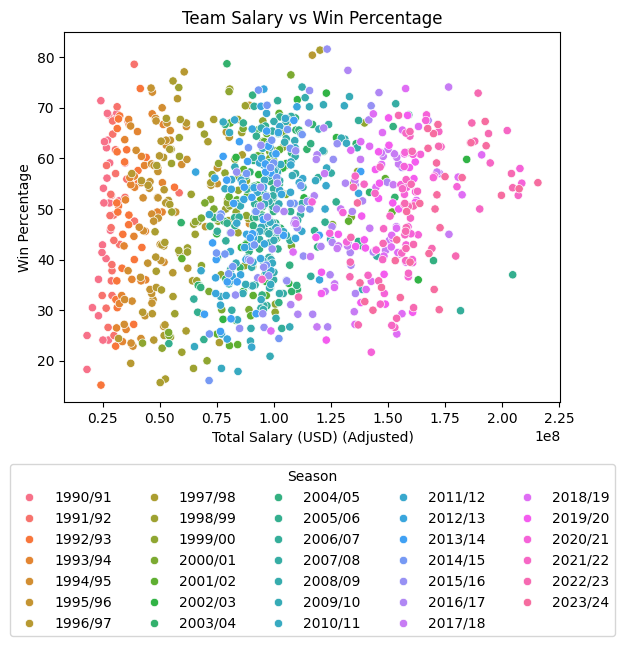

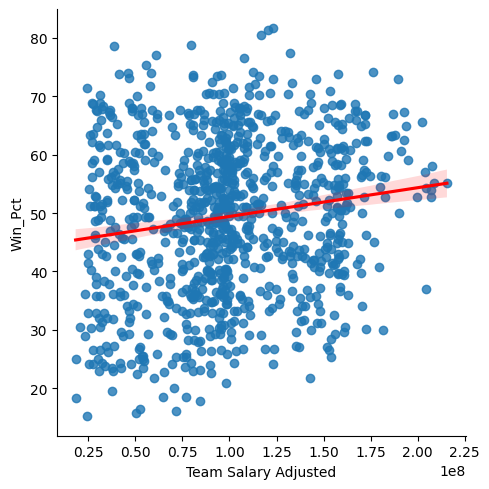

In [21]:
sns.scatterplot(data=salary_with_wins, x="Team Salary Adjusted", y="Win_Pct", hue="Season")
plt.title("Team Salary vs Win Percentage")
plt.xlabel("Total Salary (USD) (Adjusted)")
plt.ylabel("Win Percentage")
plt.legend(
    title="Season",
    bbox_to_anchor=(0.5, -0.15),  # Position (0.5 = center horizontally, -0.15 = 15% below the bottom)
    loc='upper center',           # Center alignment
    ncol=5                        # Number of columns in the legend
)
sns.lmplot(data=salary_with_wins, x="Team Salary Adjusted", y="Win_Pct", line_kws={"color": "red"})

plt.show()

This is really intersting. We see really clear stripes in the 1st plot this is because the slary goes continuously up. But at the same time visually there is not really a clear trend.

When fitting a regression line, we can see that there IS an upward trend.

In [22]:
corr, pval = pearsonr(salary_with_wins["Team Salary Adjusted"], salary_with_wins["Win_Pct"])
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3e}")

Pearson correlation: 0.154, p-value: 1.047e-06


In [23]:
corr, pval = spearmanr(salary_with_wins["Team Salary Adjusted"], salary_with_wins["Win_Pct"])
print(f"Spearman correlation: {corr:.3f}, p-value: {pval:.3e}")

Spearman correlation: 0.149, p-value: 2.532e-06


From these two we can see that ther IS a statistically significant effect. But as can be seen by 0.149, the effect is fairly small.

Btw. The Spearman correlation is probalby better here as the relationship is likely non linear. I did both just to see the result.

**Here I normalise the salary for the salary cap**

In [24]:
# Step 1: Prepare the salary cap data for merging
# Convert salary_cap_history's Season format (e.g., "1990-91") to match the format in salary_with_wins (e.g., "1990/91")
salary_cap_history['Season_Formatted'] = salary_cap_history['Season'].str.replace('-', '/')

# Step 2: Merge the DataFrames
salary_with_wins = pd.merge(
    salary_with_wins,
    salary_cap_history[['Season_Formatted', 'Salary Cap', '2022 Dollars']],
    left_on='Season',
    right_on='Season_Formatted',
    how='left'
)

# Step 3: Clean up and rename columns
salary_with_wins.drop('Season_Formatted', axis=1, inplace=True)
salary_with_wins.rename(columns={
    'Salary Cap': 'salary_cap',
    '2022 Dollars': 'salary_cap_adjusted'
}, inplace=True)

# Step 4: Verify the merge was successful
print("First 5 rows with salary cap data:")
print(salary_with_wins[['Season', 'Team', 'Team Salary', 'salary_cap', 'salary_cap_adjusted']].head())

# Check for any seasons that didn't get matched
missing_cap = salary_with_wins[salary_with_wins['salary_cap'].isna()]['Season'].unique()
if len(missing_cap) > 0:
    print(f"Seasons missing salary cap data: {missing_cap}")
else:
    print("All seasons have salary cap data!")

First 5 rows with salary cap data:
    Season       Team  Team Salary  salary_cap  salary_cap_adjusted
0  1990/91  Cleveland     14403000    11871000             25499592
1  1990/91   New York     13290000    11871000             25499592
2  1990/91    Detroit     12910000    11871000             25499592
3  1990/91  LA Lakers     12120000    11871000             25499592
4  1990/91    Atlanta     11761000    11871000             25499592
All seasons have salary cap data!


In [25]:
salary_with_wins.to_csv("data/salary_with_wins.csv", index=False)

In [26]:
salary_with_wins["salary_pct_cap"] = salary_with_wins["Team Salary Adjusted"] / salary_with_wins["salary_cap_adjusted"]
salary_with_wins.head()

,Season,Team,Team Salary,Team Salary Adjusted,SeasonStart,Wins,Games_Played,Win_Pct,Cost per Win,salary_cap,salary_cap_adjusted,salary_pct_cap
0,1990/91,Cleveland,14403000,34834960,1990,52,88,59.1,669903.08,11871000,25499592,1.366099
1,1990/91,New York,13290000,32143071,1990,47,91,51.6,683895.13,11871000,25499592,1.260533
2,1990/91,Detroit,12910000,31224004,1990,71,103,68.9,439774.70,11871000,25499592,1.22449
3,1990/91,LA Lakers,12120000,29313318,1990,63,93,67.7,465290.76,11871000,25499592,1.14956
4,1990/91,Atlanta,11761000,28445044,1990,38,83,45.8,748553.79,11871000,25499592,1.11551


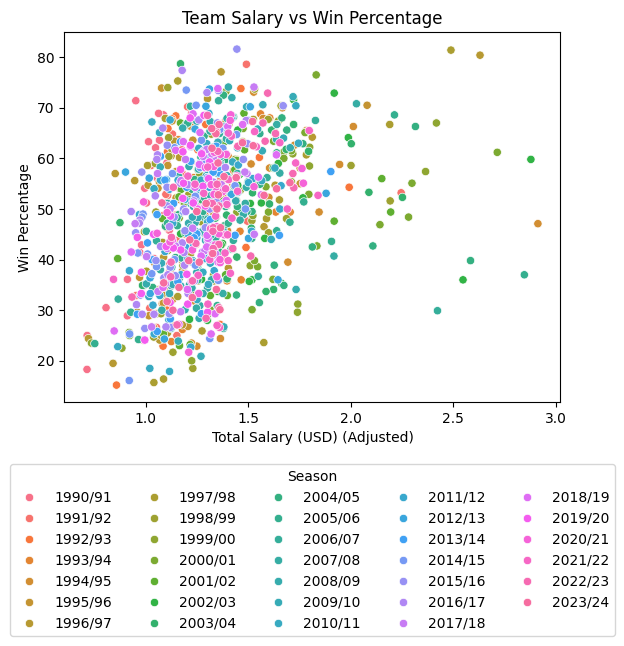

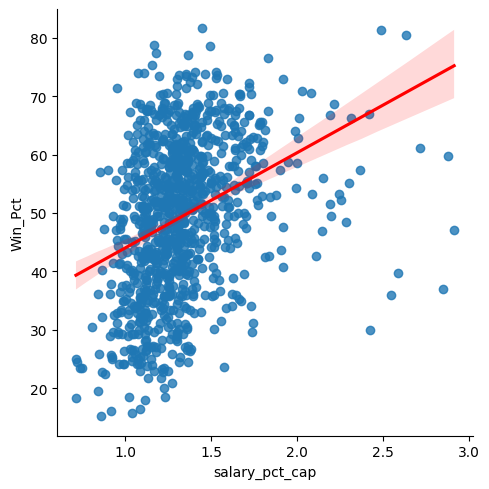

In [27]:
sns.scatterplot(data=salary_with_wins, x="salary_pct_cap", y="Win_Pct", hue="Season")
plt.title("Team Salary vs Win Percentage")
plt.xlabel("Total Salary (USD) (Adjusted)")
plt.ylabel("Win Percentage")
plt.legend(
    title="Season",
    bbox_to_anchor=(0.5, -0.15),  # Position (0.5 = center horizontally, -0.15 = 15% below the bottom)
    loc='upper center',           # Center alignment
    ncol=5                        # Number of columns in the legend
)
sns.lmplot(data=salary_with_wins, x="salary_pct_cap", y="Win_Pct", line_kws={"color": "red"})

plt.show()

In [28]:
corr, pval = spearmanr(salary_with_wins["salary_pct_cap"], salary_with_wins["Win_Pct"])
print(f"Spearman correlation: {corr:.3f}, p-value: {pval:.3e}")

Spearman correlation: 0.385, p-value: 2.203e-36


This result is actually way better, here we get a way stronger correlation for 0.385 and an EVEN smaller p value.

This shows a very clear correlation between the team spending and performance.

In [36]:
import statsmodels.api as sm
import numpy as np

# First, check for and handle any NaN values
print("X has NaN values:", salary_with_wins['salary_pct_cap'].isna().any())
print("Y has NaN values:", salary_with_wins['Win_Pct'].isna().any())

# Create a clean dataset without NaN values
clean_data = salary_with_wins.dropna(subset=['salary_pct_cap', 'Win_Pct'])

# Add constant term for intercept
X = sm.add_constant(clean_data['salary_pct_cap'])
Y = clean_data['Win_Pct']

# Check the shapes to make sure they match
print("X shape:", X.shape)
print("Y shape:", Y.shape)
    
# Try alternative approach using scikit-learn
from sklearn.linear_model import LinearRegression

X_sklearn = clean_data[['salary_pct_cap']]
model_sklearn = LinearRegression().fit(X_sklearn, Y)

# Generate predictions
cap_values = np.arange(0.9, 2.1, 0.1).reshape(-1, 1)
predictions = model_sklearn.predict(cap_values)

# Display results
for cap, win in zip(cap_values.flatten(), predictions):
    print(f"Salary Cap %: {cap:.1f}, Predicted Win %: {win:.1f}")

X has NaN values: False
Y has NaN values: False
X shape: (990, 2)
Y shape: (990,)
Salary Cap %: 0.9, Predicted Win %: 42.4
Salary Cap %: 1.0, Predicted Win %: 44.0
Salary Cap %: 1.1, Predicted Win %: 45.6
Salary Cap %: 1.2, Predicted Win %: 47.3
Salary Cap %: 1.3, Predicted Win %: 48.9
Salary Cap %: 1.4, Predicted Win %: 50.5
Salary Cap %: 1.5, Predicted Win %: 52.2
Salary Cap %: 1.6, Predicted Win %: 53.8
Salary Cap %: 1.7, Predicted Win %: 55.4
Salary Cap %: 1.8, Predicted Win %: 57.0
Salary Cap %: 1.9, Predicted Win %: 58.7
Salary Cap %: 2.0, Predicted Win %: 60.3
Salary Cap %: 2.1, Predicted Win %: 61.9


c:\Users\eliok\Documents\GitHub\uzh-esc403-data-science-project-nba\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
